# Exponential Thick Disc

Density profile : 


\begin{equation}
\label{eq:df_disc}
\rho(R, z) = \rho_{d, 0} \rho_R (R) \rho_z (z)
\end{equation}

where 

$$ \rho_R (R) = e^{\alpha R}$$

and $$ \rho_z (z) = \cosh^{-2}{\left(\frac{\beta z}{2} \right)}$$

Result is : 

\begin{equation}
\label{eq:sol_disc}
\Phi(R, z) = - 2\pi G \alpha \rho_{d, 0} \int_{0}^{\infty} dk J_0 (kR) \dfrac{I_z (k)}{(\alpha^2 + k^2)^{\frac{3}{2}}}
\end{equation}

where 
$$
\begin{equation}
\label{eq:integral}
I_z(k) = \dfrac{4}{\beta} \left\{ 1 - \dfrac{k}{k+\beta} \left[ e^{-z\beta} {}_2F_1\left(1, 1 + \frac{k}{\beta}; 2 + \frac{k}{\beta}; -e^{-z\beta} \right) + e^{z\beta} {}_2F_1\left(1, 1 + \frac{k}{\beta}; 2 + \frac{k}{\beta}; -e^{z\beta} \right)\right] \right\}
\end{equation}
$$

where $_2F_1$ is the Gaussian hypergeometric function, such that :

$$ _2F_1(a, b, c; z) = \sum_{n=0}^{\infty} \frac{(a)_n (b)_n}{(c)_n}\cdot \dfrac{z^n}{n!}$$ 

where $(a)_n$ is the Pochhammer symbol and $|z| < 1$.

This special function is implemented in scipy : https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.hyp2f1.html

**Note:**

I try here to simplify the Poisson equation the real space :
 
$$ \nabla^2 \Phi (R, z) = 4\pi G \rho_0 e^{\frac{-R}{R_d}} \cosh^{-2}{\frac{z}{z_d}}$$

which in cylindrical coordinates, with independence on the $\theta$ component reduces to:

$$ \dfrac{1}{R} \dfrac{\partial}{\partial R} \left( R \dfrac{\partial \Phi}{\partial R}\right) + \dfrac{\partial^2 \Phi}{\partial z^2} = 4\pi G \rho_0 e^{\frac{-R}{R_d}} \cosh^{-2}{\frac{z}{z_d}}$$

setting $z' = \dfrac{z}{z_d}$ and $R' = \dfrac{R}{R_d}$ , we can write simplify the equation in the following form :

$$ \dfrac{1}{R_{d}^{2}} \dfrac{1}{R'} \dfrac{\partial}{\partial R'} \left(R' \dfrac{\partial \Phi}{\partial R'}\right) + \dfrac{1}{z_{d}^{2}}\dfrac{\partial^2 \Phi}{\partial z'^2} = 4\pi G \rho_0 e^{-R'} \cosh^{-2}{z'}$$

Now, since $M_d = \rho_0 R_d \int_{0}^{2\pi} d\theta \int_{0}^{z_d} dz \int_{0}^{R_d} dr = 2\pi \rho_0 R_d^2 z_d$

We get :
$$ \dfrac{1}{R_{d}^{2}} \dfrac{1}{R'} \dfrac{\partial}{\partial R'} \left(R' \dfrac{\partial \Phi}{\partial R'}\right) + \dfrac{1}{z_{d}^{2}}\dfrac{\partial^2 \Phi}{\partial z'^2} = \frac{G M_d}{R_d^2 z_d}  e^{-R'} \cosh^{-2}{z'}$$

If we define $\phi'= \frac{\phi}{G M_d/z_d}$

$$ \dfrac{1}{R'} \dfrac{\partial}{\partial R'} \left(R' \dfrac{\partial \Phi'}{\partial R'}\right) + \dfrac{R_d^2}{z_{d}^{2}}\dfrac{\partial^2 \Phi'}{\partial z'^2} = e^{-R'} \cosh^{-2}{z'}$$

Usually one defines $\eta = \frac{z_d}{R_d} $

$$ \dfrac{1}{R'} \dfrac{\partial}{\partial R'} \left(R' \dfrac{\partial \Phi'}{\partial R'}\right) + \dfrac{1}{\eta^{2}}\dfrac{\partial^2 \Phi'}{\partial z'^2} = e^{-R'} \cosh^{-2}{z'}$$

Now the neural network should be function of 3 variables: $R'$, $z'$ and $\eta$.
Physically motivated values of $\eta$ can be around $0.1$ - $0.2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as itg
from scipy.special import hyp2f1, jv

$R_d$ in the range $[2, 6]$ is ok

$z_d$, for now, we will set it in order to have $\dfrac{z_d}{R_d}=0.2$

The domain where to solve the equations can be between $\dfrac{R}{R_d} = [0;20]$  and $\dfrac{z}{z_d} = [0;5]$

We should also investigate where and when is possible to solve the equation via approximations.

To compare our results, we set here :
- $R_d = 4$  
- $\dfrac{z_d}{R_d}=0.2$  
- $M_d = 10^{10.5}$   

In [2]:
Rd = 4
zd = 0.2 * Rd
alpha = 1 / Rd
beta = 2 / zd

In [3]:
def potential_integral(k, R, z, alpha, beta):
    return jv(0, k * R) * Iz(z, k, b=beta) / (alpha**2 + k**2)**1.5

In [4]:
def Iz(z, k, b):
    factor = k / (k + b)
    first_part = np.exp(-z * b) * hyp2f1(1, 1 + k / b, 2 + k / b, -np.exp(-z * b))
    second_part = np.exp(z * b) * hyp2f1(1, 1 + k / b, 2 + k / b, -np.exp(z * b))
    
    return (4 / b) * (1 - factor * (first_part + second_part))

We can integrate over a domain $R \times z$ using the `quad_vec` function : 

In [5]:
Rtab = np.linspace(0, 20, 100) * Rd
ztab = np.linspace(0, 5, 100) * zd

Rv, zv = np.meshgrid(Rtab, ztab)

In [6]:
vec_sol = itg.quad_vec(potential_integral, a=0, b=100, args=(Rv, zv, alpha, beta))

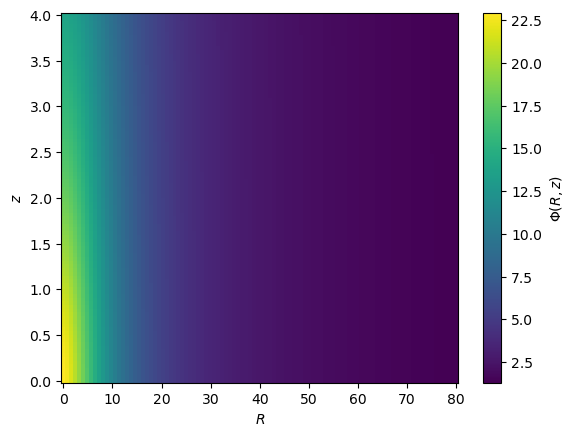

In [7]:
plt.figure()
plt.pcolormesh(Rv, zv, vec_sol[0])
plt.xlabel("$R$")
plt.ylabel("$z$")
plt.colorbar(label="$\Phi(R, z)$");

We want to test with the data available. First column is $R$, second column is $z$ and the third column is the gravitational potential. 

In [19]:
data = np.loadtxt("test_phi_grid.dat")

In [9]:
R_test, z_test, phi_test = data.T

In [10]:
R_test = R_test.reshape(250, 250)
z_test = z_test.reshape(250, 250)
phi_test = phi_test.reshape(250, 250)

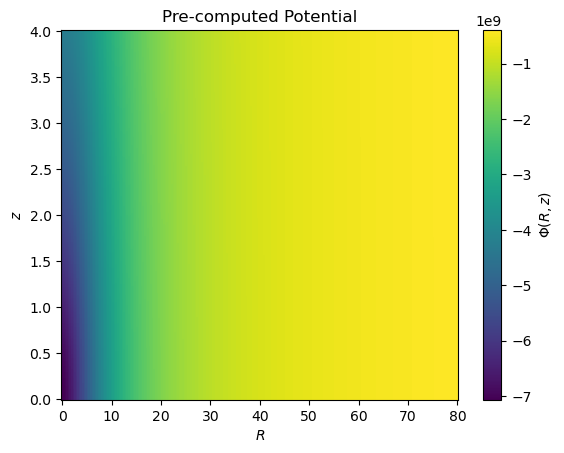

In [11]:
plt.figure()
plt.title('Pre-computed Potential')
plt.pcolormesh(R_test, z_test, phi_test)
plt.xlabel("$R$")
plt.ylabel("$z$")
plt.colorbar(label="$\Phi(R, z)$");

In [12]:
%%time
phi = itg.quad_vec(potential_integral, a=0, b=200, args=(R_test, z_test, alpha, beta))

CPU times: user 8min 12s, sys: 1.28 s, total: 8min 13s
Wall time: 8min 13s


In [13]:
Md = 10**(10.5)
G = 1 # 6.674 * 10 ** (-11)

In [14]:
phi_ = - (G * Md)/(2 * zd * Rd**3) * phi[0]

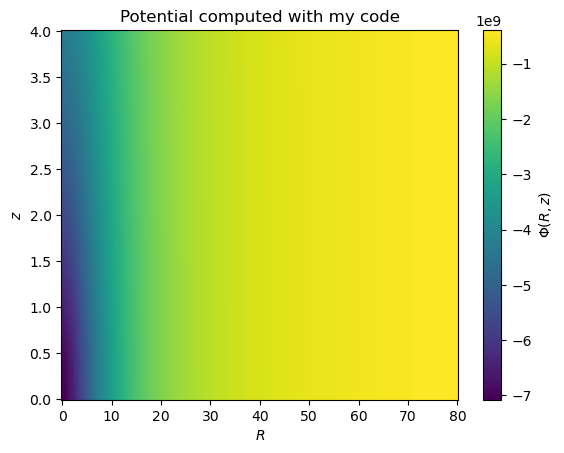

In [15]:
plt.figure()
plt.title('Potential computed with my code')
plt.pcolormesh(R_test, z_test, phi_)
plt.xlabel("$R$")
plt.ylabel("$z$")
plt.colorbar(label="$\Phi(R, z)$");

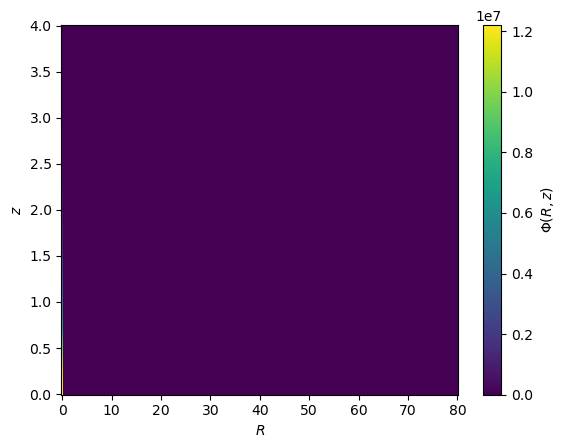

In [16]:
plt.figure()
plt.pcolormesh(R_test, z_test, np.abs(phi_test - phi_))
plt.xlabel("$R$")
plt.ylabel("$z$")
plt.colorbar(label="$\Phi(R, z)$");

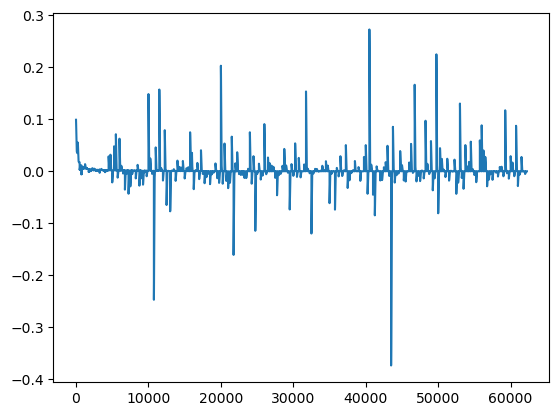

In [17]:
diff = phi_test.flatten() - phi_.flatten()
plt.plot(diff[250:]);

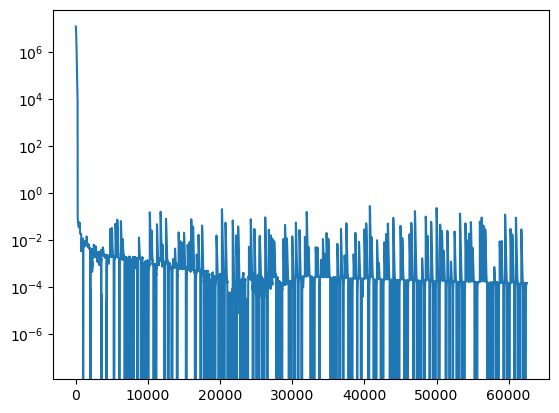

In [18]:
plt.plot(diff)
plt.yscale('log');